# Dataset Network Analysis

This notebook analyzes the network of keyword co-occurrences in the collected Bluesky posts dataset. 
It loads the data, extracts keywords, builds a co-occurrence graph, calculates network metrics, and visualizes the structure.

In [13]:
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from itertools import combinations
from networkx.algorithms import community
from matplotlib.lines import Line2D
from tqdm.notebook import tqdm
from pyvis.network import Network

# Display settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

In [14]:
# --- CONFIGURATION ---
INPUT_DIR = "./downloaded_data"
OUTPUT_BASE_DIR = "./analysis_results"
MIN_CO_OCCURRENCES = 1  # Minimum co-occurrences to create an edge

# Ensure output directory exists
os.makedirs(OUTPUT_BASE_DIR, exist_ok=True)

In [15]:
def load_dataset(filename):
    filepath = os.path.join(INPUT_DIR, filename)
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return None
    
    print(f"Loading {filepath}...")
    df = pd.read_csv(filepath)
    print(f"Loaded {len(df)} posts.")
    return df

In [16]:
def analyze_network(df, config_name):
    print(f"\n{'='*80}")
    print(f"ANALYZING: {config_name}")
    print(f"{'='*80}")

    # 1. Extract Keywords
    if 'keyword' not in df.columns:
        print("Error: 'keyword' column missing.")
        return
        
    keywords = df['keyword'].dropna().unique().tolist()
    print(f"Unique Keywords found: {len(keywords)}")
    
    # Create specific output directory
    out_dir = os.path.join(OUTPUT_BASE_DIR, config_name)
    os.makedirs(out_dir, exist_ok=True)

    # 2. Compute Co-occurrences
    print("Computing co-occurrences...")
    co_occurrence_data = []
    
    # Pre-calculate text presence for speed
    keyword_indices = {}
    for kw in tqdm(keywords, desc="Indexing keywords"):
        # Case-insensitive matching
        mask = df['text'].str.contains(kw, case=False, na=False, regex=False)
        keyword_indices[kw] = set(df[mask].index)
        
    for kw1, kw2 in tqdm(combinations(keywords, 2), total=len(keywords)*(len(keywords)-1)//2, desc="Calculating Pairs"):
        common_indices = keyword_indices[kw1].intersection(keyword_indices[kw2])
        count = len(common_indices)

        if count >= MIN_CO_OCCURRENCES:
            co_occurrence_data.append({
                'w1': kw1,
                'w2': kw2,
                'count': count
            })
            
    co_df = pd.DataFrame(co_occurrence_data)
    print(f"Found {len(co_df)} pairs with co-occurrences >= {MIN_CO_OCCURRENCES}")

    # Export Co-occurrences
    co_df.to_csv(os.path.join(out_dir, "co_occurrences.csv"), index=False)
    print("Co-occurrence data saved to co_occurrences.csv")
    
    if len(co_df) == 0:
        print("No co-occurrences found. Skipping graph build.")
        return

    # 3. Build Graph
    G = nx.Graph()
    G.add_nodes_from(keywords)
    
    edges = []
    for _, row in co_df.iterrows():
        edges.append((row['w1'], row['w2'], {'weight': row['count']}))
    G.add_edges_from(edges)
    
    print(f"Graph constructed: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    
    # 4. Calculate Metrics
    degrees = dict(G.degree())
    strength = dict(G.degree(weight='weight'))
    betweenness = nx.betweenness_centrality(G, weight='weight')
    clustering = nx.clustering(G, weight='weight')
    
    # Global Metrics
    density = nx.density(G)
    transitivity = nx.transitivity(G)
    
    if nx.is_connected(G):
        closeness = nx.closeness_centrality(G, distance='weight')
        diameter = nx.diameter(G)
    else:
        # Handle disconnected graph for closeness
        closeness = {}
        for c in nx.connected_components(G):
            subg = G.subgraph(c)
            closeness.update(nx.closeness_centrality(subg, distance='weight'))
        
        # Diameter of largest component
        if G.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(G), key=len)
            diameter = nx.diameter(G.subgraph(largest_cc))
        else:
            diameter = 0
            
    # Community Detection
    communities = []
    modularity = 0
    if G.number_of_edges() > 0:
        communities = list(community.greedy_modularity_communities(G, weight='weight'))
        modularity = community.modularity(G, communities, weight='weight')
    
    # Save Node Metrics
    metrics_df = pd.DataFrame({
        'keyword': keywords,
        'degree': [degrees.get(k,0) for k in keywords],
        'strength': [strength.get(k,0) for k in keywords],
        'betweenness': [betweenness.get(k,0) for k in keywords],
        'closeness': [closeness.get(k,0) for k in keywords],
        'clustering': [clustering.get(k,0) for k in keywords]
    }).sort_values('degree', ascending=False)
    
    metrics_df.to_csv(os.path.join(out_dir, "node_metrics.csv"), index=False)
    print("Metrics saved to node_metrics.csv")
    
    # Save Global Metrics
    global_metrics = {
        'language': config_name,
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': density,
        'diameter': diameter,
        'avg_degree': sum(degrees.values()) / len(G) if len(G) > 0 else 0,
        'avg_strength': sum(strength.values()) / len(G) if len(G) > 0 else 0,
        'modularity': modularity,
        'global_clustering': transitivity
    }
    pd.DataFrame([global_metrics]).to_csv(os.path.join(out_dir, "global_metrics.csv"), index=False)
    print("Global metrics saved to global_metrics.csv")

    # 5. Visualizations
    visualize_network(G, degrees, strength, betweenness, closeness, clustering, 
                      edge_weights=[d['weight'] for u,v,d in G.edges(data=True)], 
                      communities=communities, out_dir=out_dir, title=config_name)
    
    return G, metrics_df

In [17]:
def visualize_network(G, degrees, strength, betweenness, closeness, clustering, edge_weights, communities, out_dir, title):
    # Node Sizes
    node_sizes = [degrees[n] * 100 + 300 for n in G.nodes()]
    
    # Layout
    pos = nx.spring_layout(G, k=0.5, seed=42)
    
    # Common Edge Styling Calculation
    edge_cmap = plt.cm.viridis
    if edge_weights:
        max_w = max(edge_weights)
    else:
        max_w = 1
        
    def get_edge_style(weight):
        width = 1.0 + (weight / max_w) * 10
        color = edge_cmap(weight / max_w * 0.7 + 0.3)
        return width, color

    # =========================================
    # 1. Main Network Plot (Spring Layout)
    # =========================================
    plt.figure(figsize=(16, 12))
    
    # Custom Node Colors
    node_colors = ['skyblue'] * len(G)
    cmap = plt.get_cmap('tab20')
    if communities:
        color_map = {}
        for i, comm in enumerate(communities):
            for node in comm:
                color_map[node] = cmap(i % 20)
        node_colors = [color_map.get(n, 'skyblue') for n in G.nodes()]
    
    # Draw Edges
    if edge_weights:
        for u, v, d in G.edges(data=True):
            weight = d.get('weight', 1)
            width, color = get_edge_style(weight)
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, 
                                   alpha=0.7, edge_color=[color])
    
    # Draw Nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, 
                           alpha=0.9, edgecolors='gray', linewidths=1.5)
    
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    # Legends (Main Plot)
    if communities:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Community {i+1}',
                          markerfacecolor=cmap(i % 20), markersize=12, markeredgecolor='black')
                          for i in range(len(communities))]
        plt.legend(handles=legend_elements, loc='upper right', title="Communities", 
                   fontsize=12, title_fontsize=14, frameon=False, bbox_to_anchor=(1.15, 1))

    plt.title(f"Keyword Network: {title}", fontsize=20, fontweight='bold')
    plt.axis('off')
    plt.savefig(os.path.join(out_dir, "network_graph.png"), bbox_inches='tight')
    plt.show()

    # =========================================
    # 2. Enhanced Circular Visualization
    # =========================================
    plt.figure(figsize=(18, 18))
    pos_circ = nx.circular_layout(G)
    
    if edge_weights:
        for u, v, d in G.edges(data=True):
            weight = d.get('weight', 1)
            width, color = get_edge_style(weight)
            nx.draw_networkx_edges(G, pos_circ, edgelist=[(u, v)], width=width, 
                                   alpha=0.6, edge_color=[color], 
                                   connectionstyle=f'arc3,rad=0.2', 
                                   arrows=True, arrowstyle='-')

    nx.draw_networkx_nodes(G, pos_circ, node_size=[s * 1.5 for s in node_sizes], 
                           node_color=node_colors, alpha=1.0, 
                           edgecolors='black', linewidths=2.5)
    
    pos_labels = {k: (v[0]*1.1, v[1]*1.1) for k, v in pos_circ.items()}
    nx.draw_networkx_labels(G, pos_labels, font_size=14, font_weight='bold')

    # Legends (Circular Plot)
    if communities:
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Community {i+1}',
                          markerfacecolor=cmap(i % 20), markersize=12, markeredgecolor='black')
                          for i in range(len(communities))]
        plt.legend(handles=legend_elements, loc='upper right', title="Communities", 
                   fontsize=12, title_fontsize=14, frameon=False, bbox_to_anchor=(1.15, 1))

    sm = plt.cm.ScalarMappable(cmap=edge_cmap, norm=plt.Normalize(vmin=0, vmax=max_w))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation='vertical', fraction=0.03, pad=0.03)
    cbar.set_label('Co-occurrence Weight', fontsize=12)

    plt.title(f"Circular Layout: {title}", fontsize=22, fontweight='bold', pad=30)
    plt.axis('off')
    plt.savefig(os.path.join(out_dir, "circular_graph_enhanced.png"), bbox_inches='tight', dpi=300)
    plt.show()

    # =========================================
    # 3. Consolidated Metrics Dashboard
    # =========================================
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f"Metric Distributions & Heatmap: {title}", fontsize=20, fontweight='bold')
    
    # Flatten axes for easier indexing if needed or access directly
    ax1, ax2, ax3 = axes[0]
    ax4, ax5, ax6 = axes[1]

    # A. Degree
    ax1.hist(list(degrees.values()), bins=20, color='steelblue', edgecolor='black')
    ax1.set_title("Degree Distribution")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Frequency")
    ax1.grid(axis='y', alpha=0.3)

    # B. Strength
    ax2.hist(list(strength.values()), bins=20, color='orange', edgecolor='black')
    ax2.set_title("Strength Distribution")
    ax2.set_xlabel("Strength")
    ax2.grid(axis='y', alpha=0.3)

    # C. Betweenness
    ax3.hist(list(betweenness.values()), bins=20, color='green', edgecolor='black')
    ax3.set_title("Betweenness Centrality")
    ax3.set_xlabel("Betweenness")
    ax3.grid(axis='y', alpha=0.3)

    # D. Closeness
    if closeness:
        ax4.hist(list(closeness.values()), bins=20, color='purple', edgecolor='black')
    ax4.set_title("Closeness Centrality")
    ax4.set_xlabel("Closeness")
    ax4.grid(axis='y', alpha=0.3)

    # E. Clustering
    ax5.hist(list(clustering.values()), bins=20, color='red', edgecolor='black')
    ax5.set_title("Clustering Coefficient")
    ax5.set_xlabel("Coefficient")
    ax5.grid(axis='y', alpha=0.3)

    # F. Adjacency Heatmap
    adj_matrix = nx.to_pandas_adjacency(G, weight='weight')
    im = ax6.imshow(adj_matrix, cmap='Blues', interpolation='nearest', aspect='auto')
    fig.colorbar(im, ax=ax6, label='Co-occurrence')
    ax6.set_title("Adjacency Heatmap")
    
    # Only show labels if graph is small enough to be readable
    if len(G) <= 30:
        ax6.set_xticks(range(len(adj_matrix)))
        ax6.set_yticks(range(len(adj_matrix)))
        ax6.set_xticklabels(adj_matrix.columns, rotation=90, fontsize=8)
        ax6.set_yticklabels(adj_matrix.index, fontsize=8)
    else:
        ax6.set_xticks([])
        ax6.set_yticks([])
        ax6.set_xlabel("Nodes")
        ax6.set_ylabel("Nodes")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(out_dir, "metrics_dashboard.png"), bbox_inches='tight')
    plt.show()

    # =========================================
    # 4. Interactive PyVis Graph
    # =========================================
    try:
        # Initial options for layout and physics
        net = Network(height="750px", width="100%", bgcolor="#ffffff", font_color="black")
        
        # Add Nodes with Size scaled by degree
        # PyVis uses 'value' for scaling size
        for node in G.nodes():
            # Scale degree for visibility
            size_val = degrees.get(node, 1)
            group_val = next((i for i, c in enumerate(communities) if node in c), 0) if communities else 0
            
            net.add_node(node, label=node, title=f"{node} (Degree: {size_val})", 
                         value=size_val, group=group_val)
        
        # Add Edges with Width scaled by weight
        # PyVis uses 'value' for scaling width if 'width' is not fixed
        # We use 'value' to let PyVis handle scaling or 'width' for absolute pixels
        if edge_weights:
            max_w_pyvis = max(edge_weights) if edge_weights else 1
            for u, v, d in G.edges(data=True):
                w = d.get('weight', 1)
                # Viridis Coloring
                norm_w = w / max_w_pyvis
                edge_rgba = edge_cmap(norm_w)
                import matplotlib.colors as mcolors
                edge_hex = mcolors.to_hex(edge_rgba)
                
                net.add_edge(u, v, value=w, title=f"Co-occurrences: {w}", 
                             color=edge_hex, opacity=0.8)
        
        net.show_buttons() 
        output_html = os.path.join(out_dir, "interactive_graph.html")
        net.save_graph(output_html)
        print(f"Interactive graph saved to {output_html}")
        
    except ImportError:
        print("PyVis not installed. Skipping interactive graph. Run 'pip install pyvis' to enable.")
    except Exception as e:
        print(f"Error creating interactive graph: {e}")


Loading ./downloaded_data\Germany_bluesky_posts.csv...
Loaded 10766 posts.

ANALYZING: Germany_bluesky_posts
Unique Keywords found: 18
Computing co-occurrences...


Indexing keywords:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating Pairs:   0%|          | 0/153 [00:00<?, ?it/s]

Found 76 pairs with co-occurrences >= 1
Co-occurrence data saved to co_occurrences.csv
Graph constructed: 18 nodes, 76 edges.
Metrics saved to node_metrics.csv
Global metrics saved to global_metrics.csv


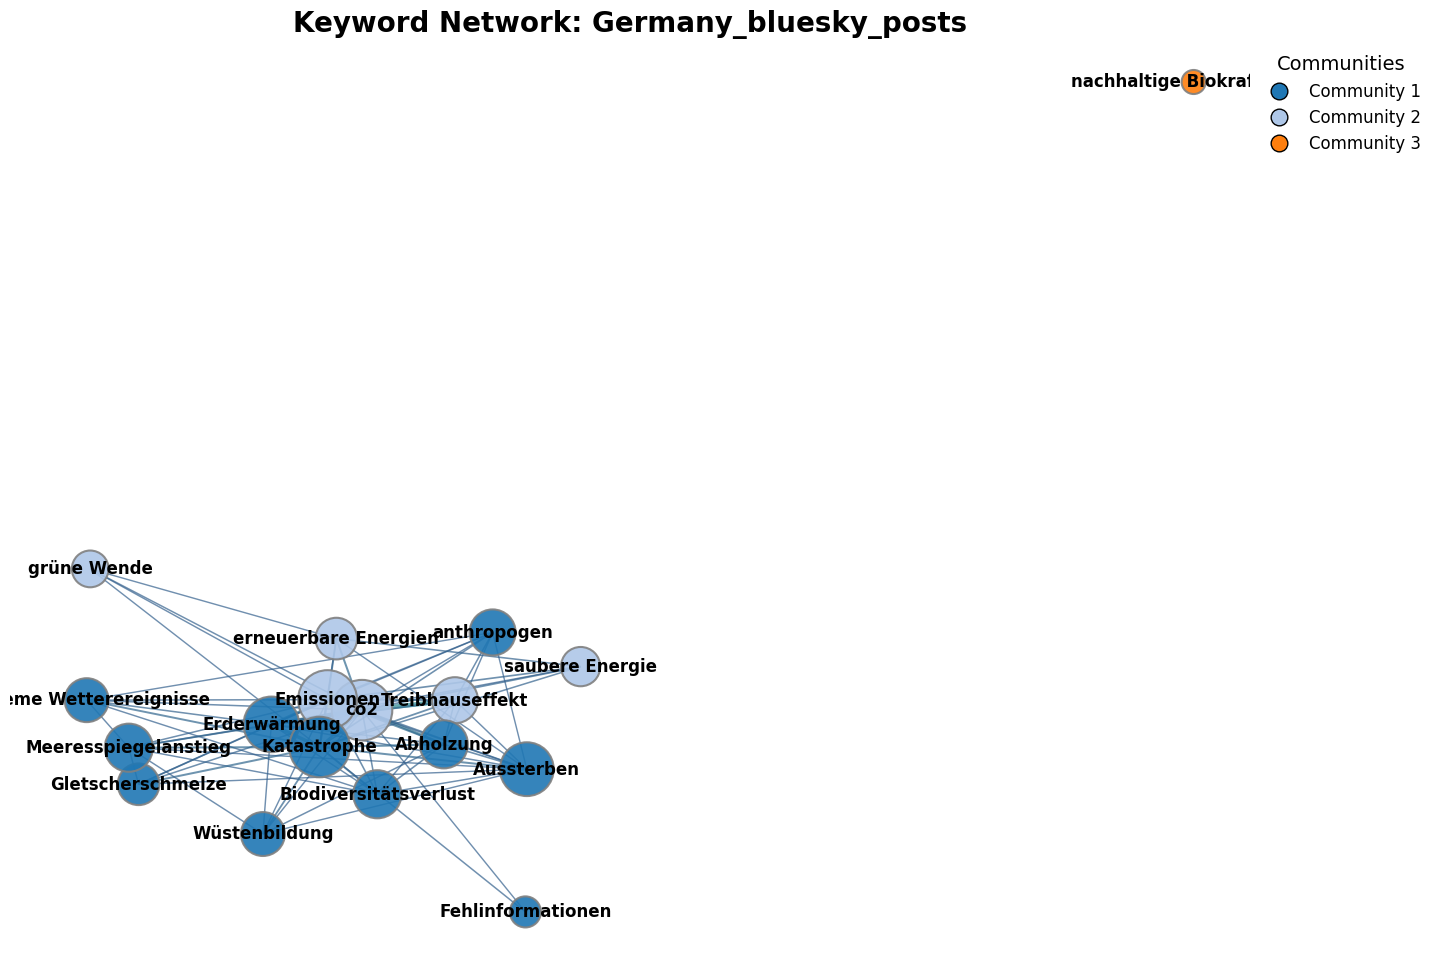

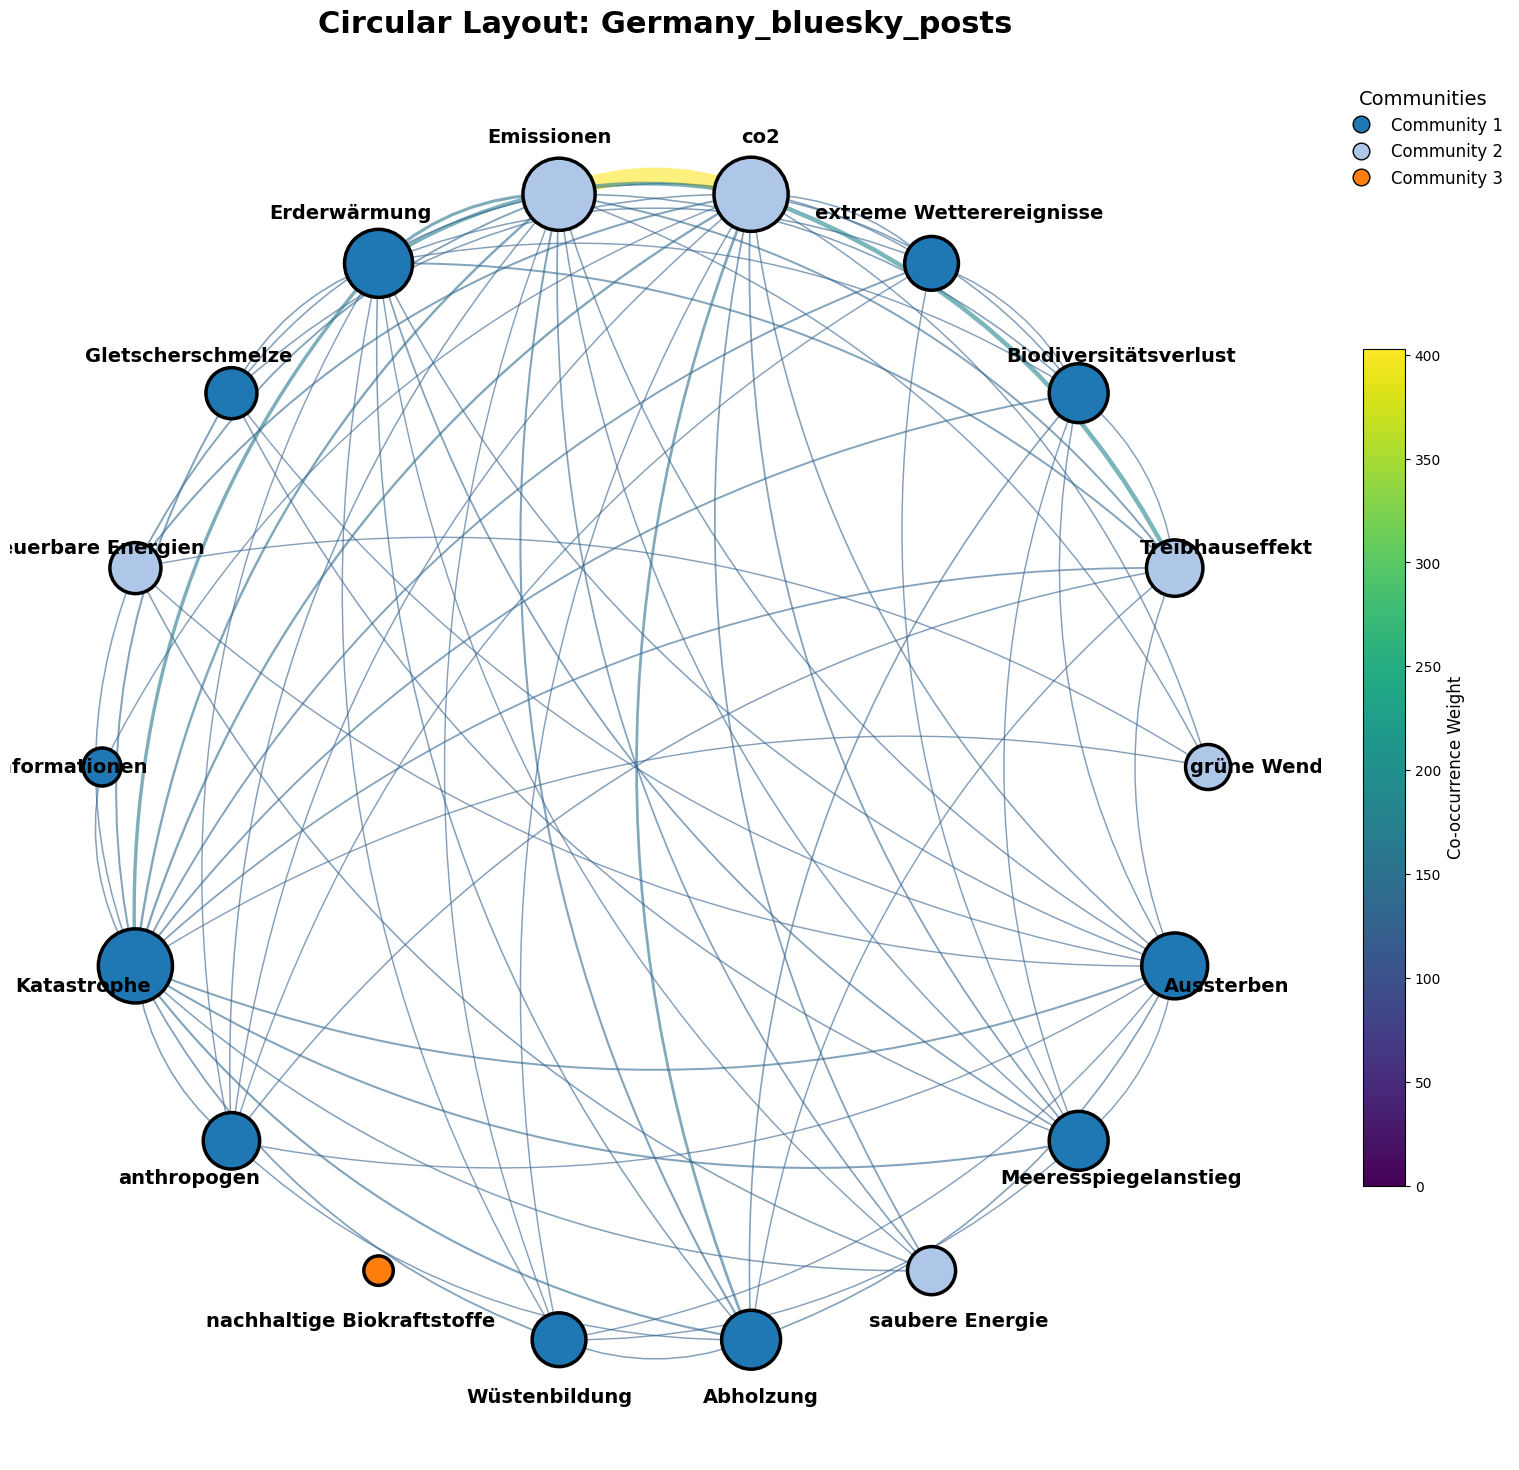

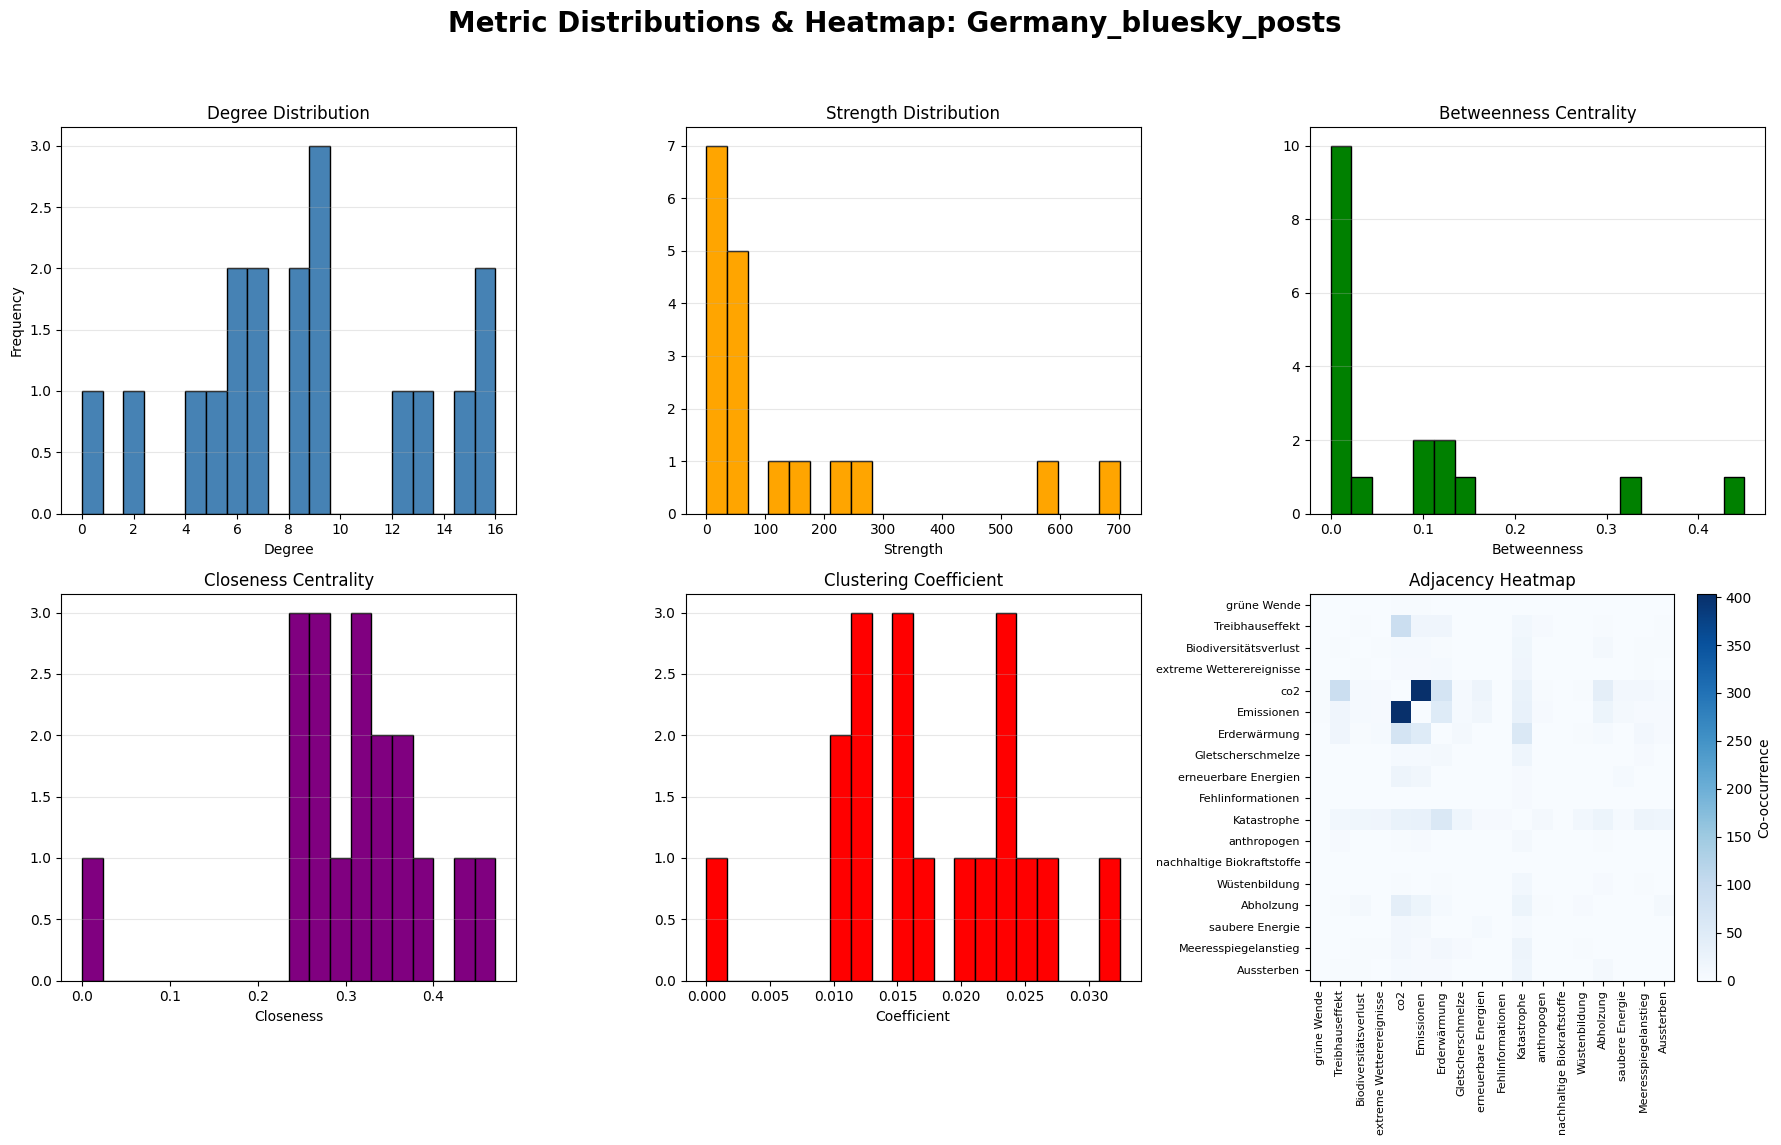

Interactive graph saved to ./analysis_results\Germany_bluesky_posts\interactive_graph.html
Loading ./downloaded_data\Global_bluesky_posts.csv...
Loaded 17285 posts.

ANALYZING: Global_bluesky_posts
Unique Keywords found: 18
Computing co-occurrences...


Indexing keywords:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating Pairs:   0%|          | 0/153 [00:00<?, ?it/s]

Found 99 pairs with co-occurrences >= 1
Co-occurrence data saved to co_occurrences.csv
Graph constructed: 18 nodes, 99 edges.
Metrics saved to node_metrics.csv
Global metrics saved to global_metrics.csv


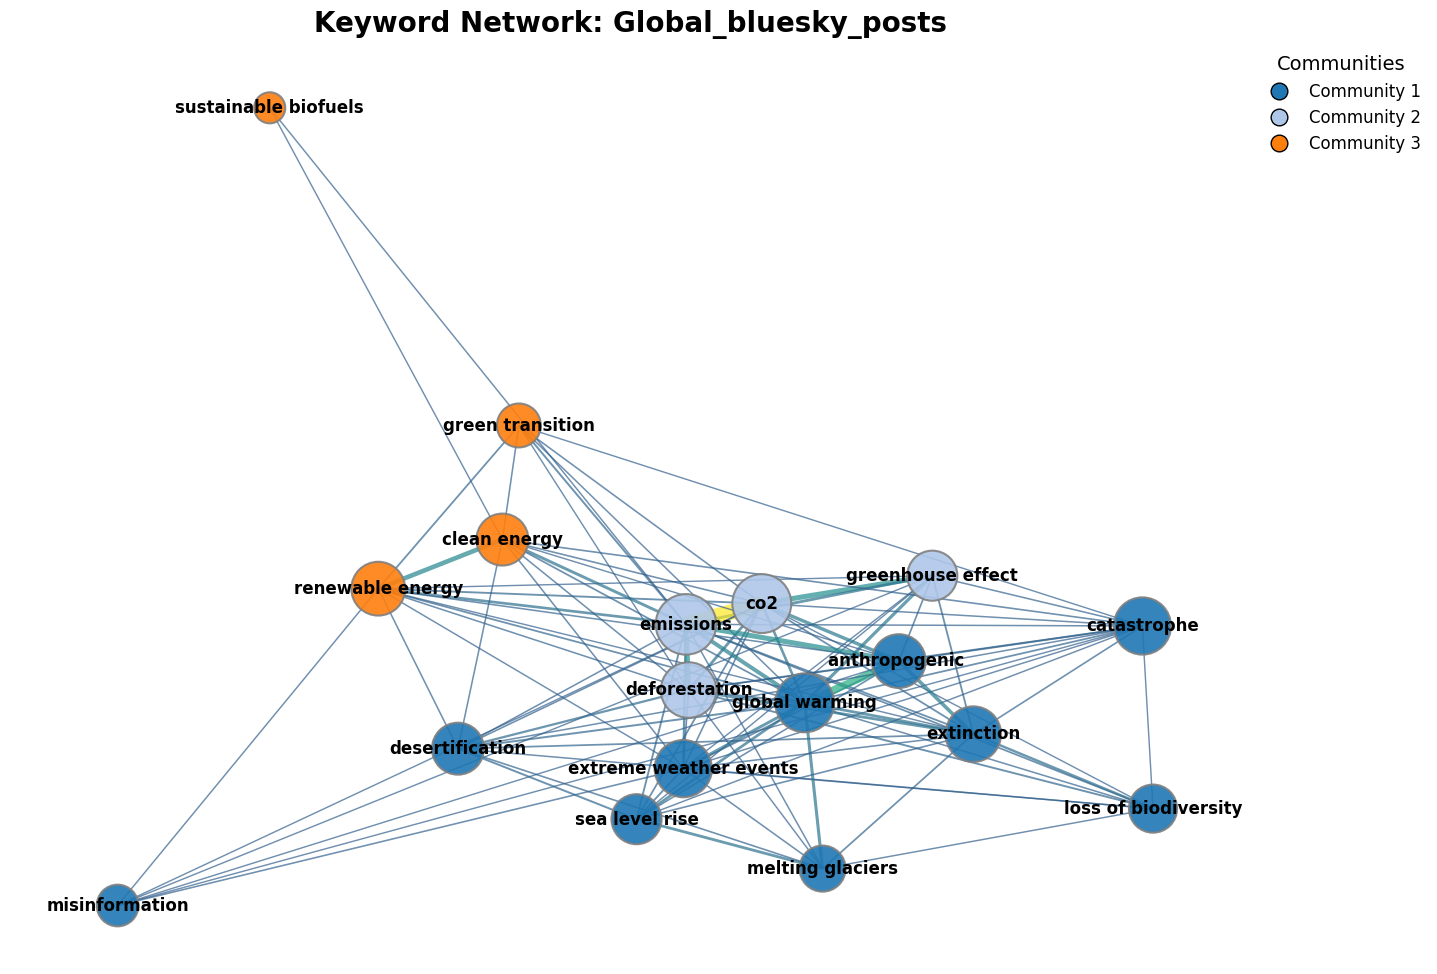

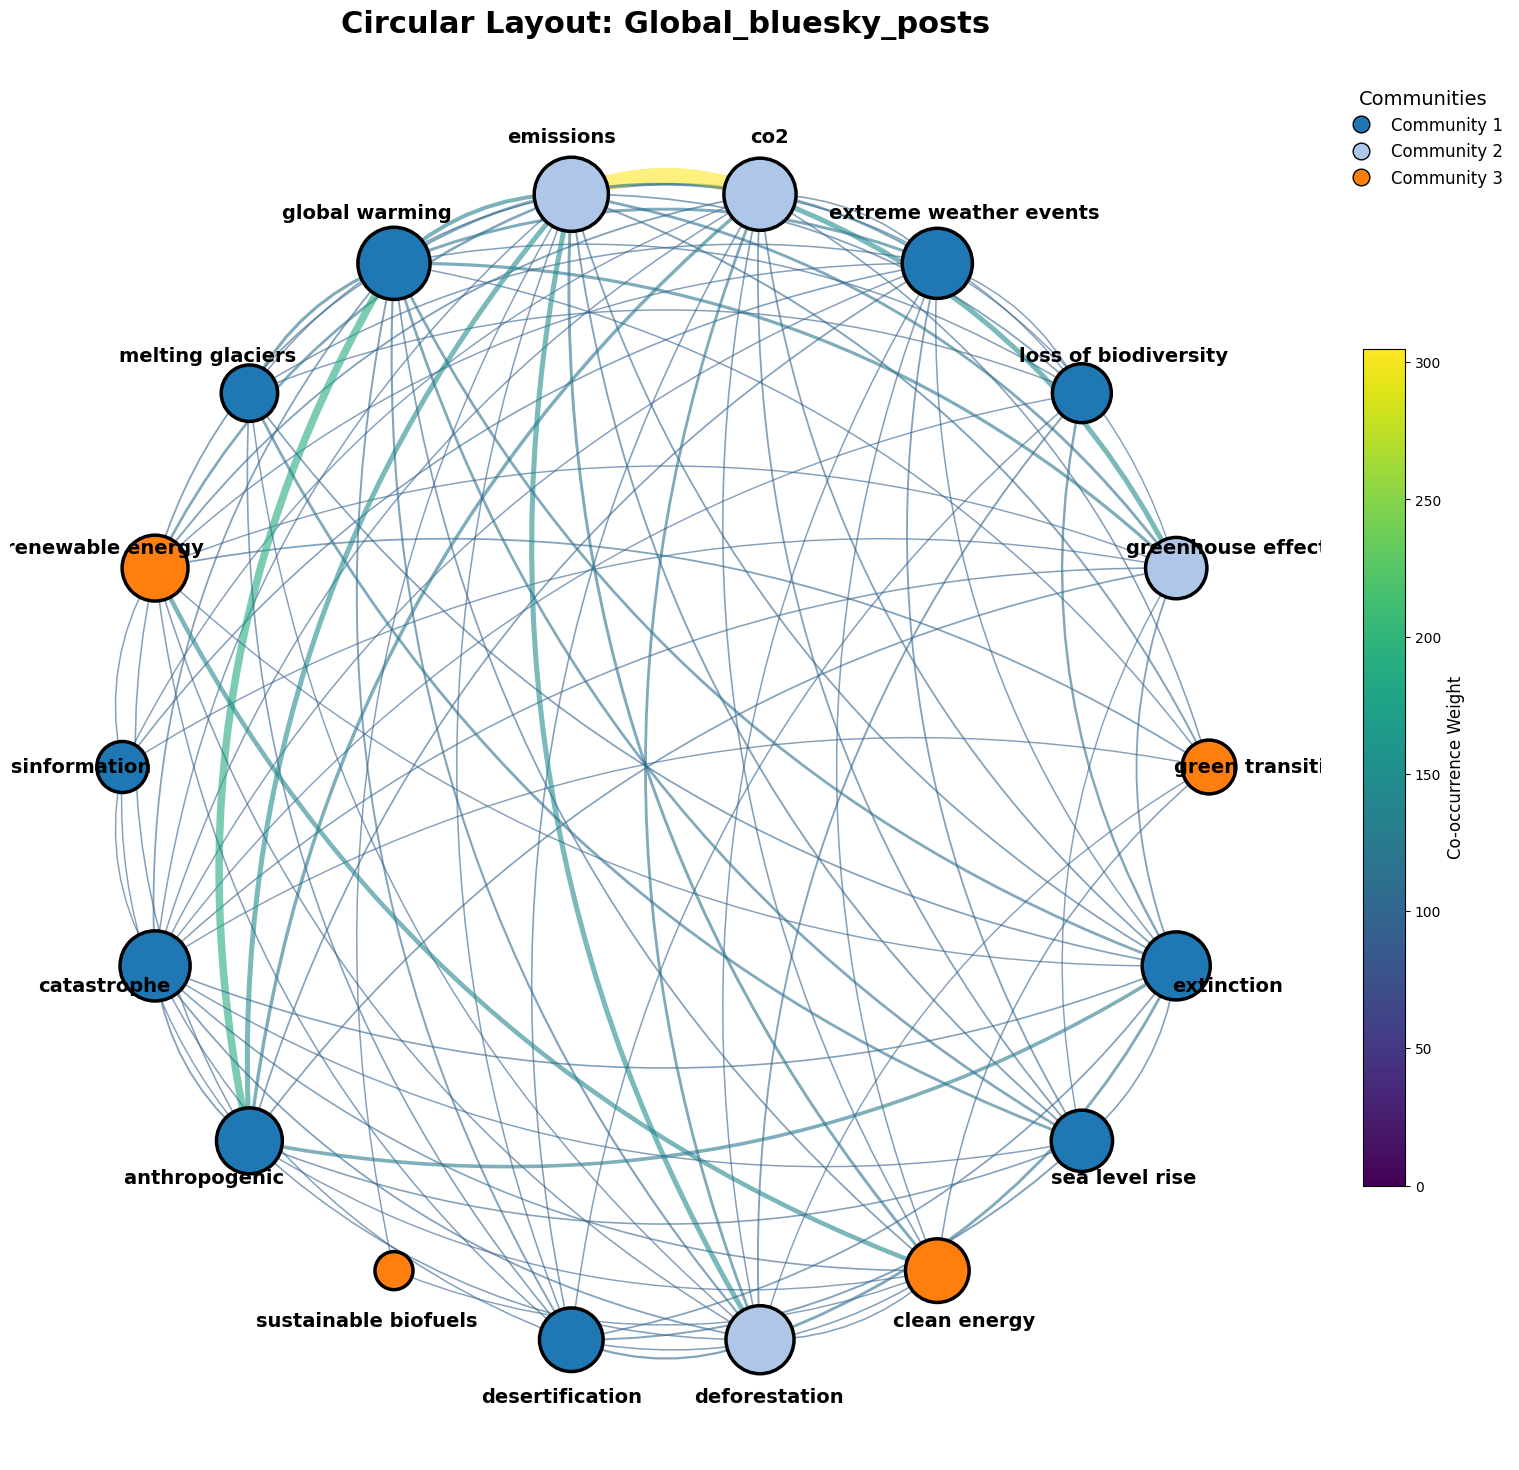

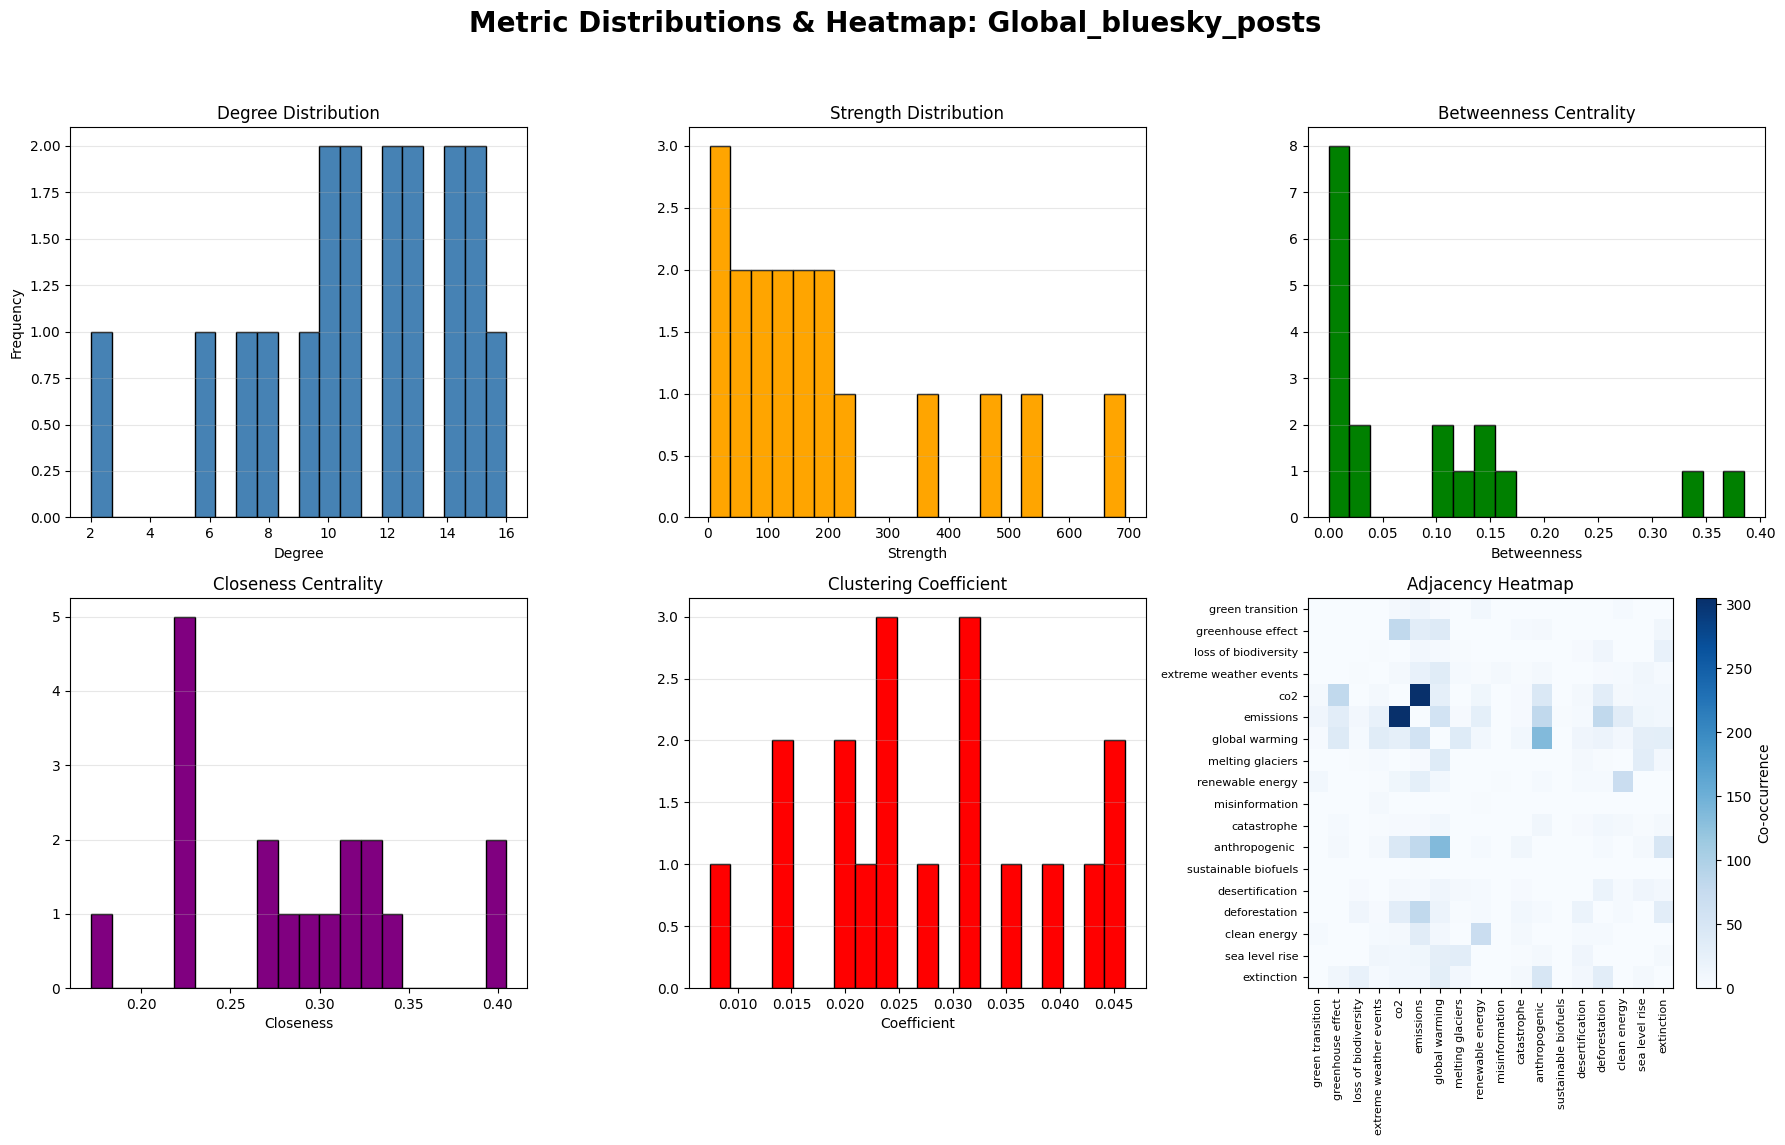

Interactive graph saved to ./analysis_results\Global_bluesky_posts\interactive_graph.html
Loading ./downloaded_data\Italy_bluesky_posts.csv...
Loaded 6039 posts.

ANALYZING: Italy_bluesky_posts
Unique Keywords found: 17
Computing co-occurrences...


Indexing keywords:   0%|          | 0/17 [00:00<?, ?it/s]

Calculating Pairs:   0%|          | 0/136 [00:00<?, ?it/s]

Found 44 pairs with co-occurrences >= 1
Co-occurrence data saved to co_occurrences.csv
Graph constructed: 17 nodes, 44 edges.
Metrics saved to node_metrics.csv
Global metrics saved to global_metrics.csv


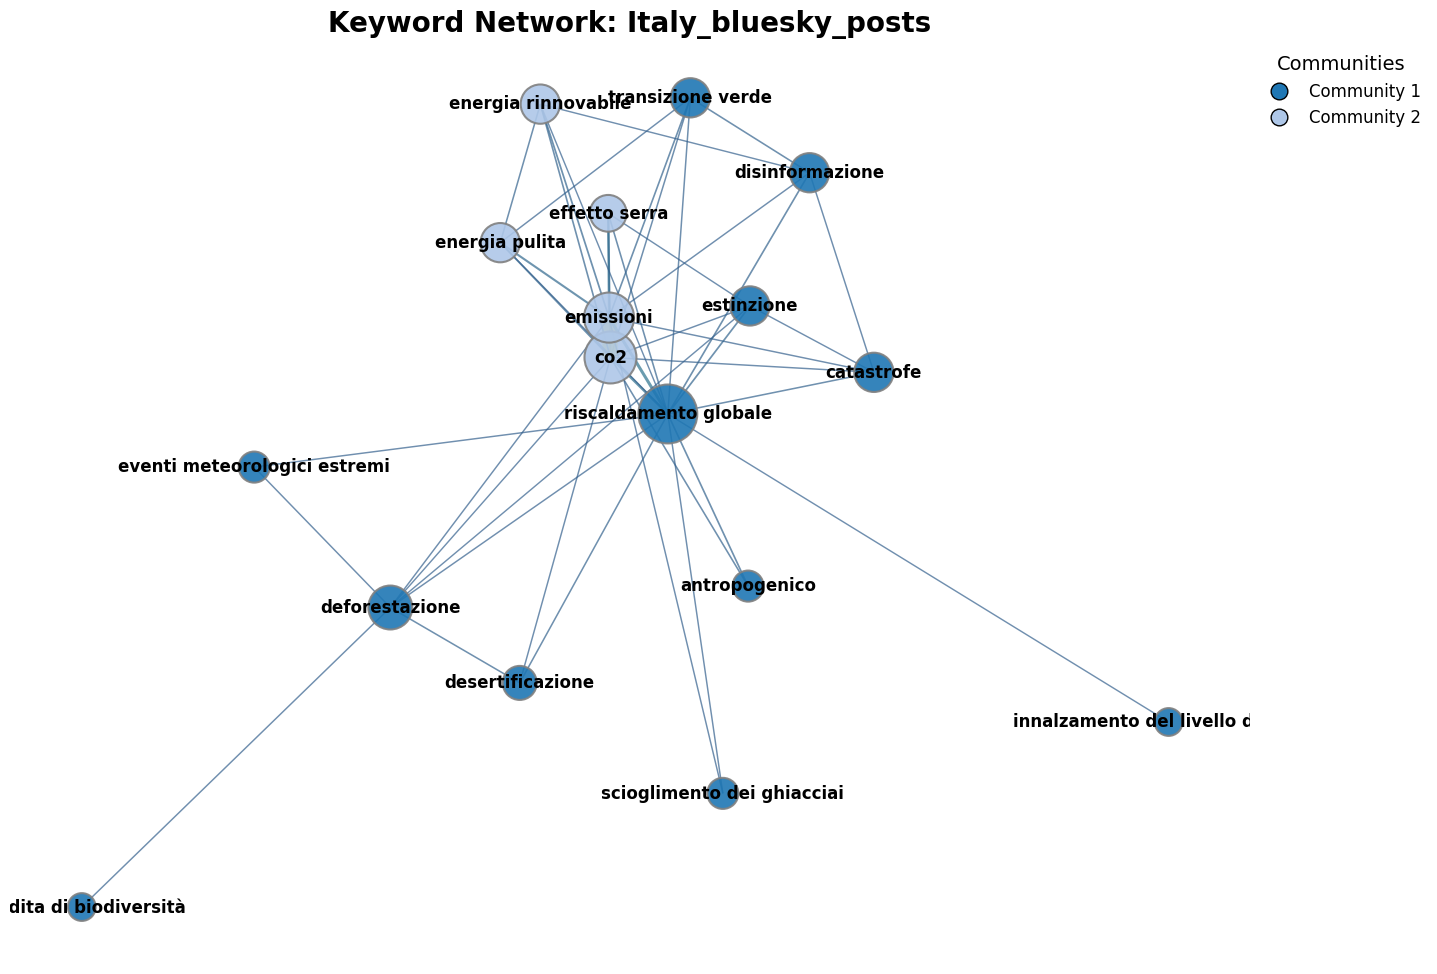

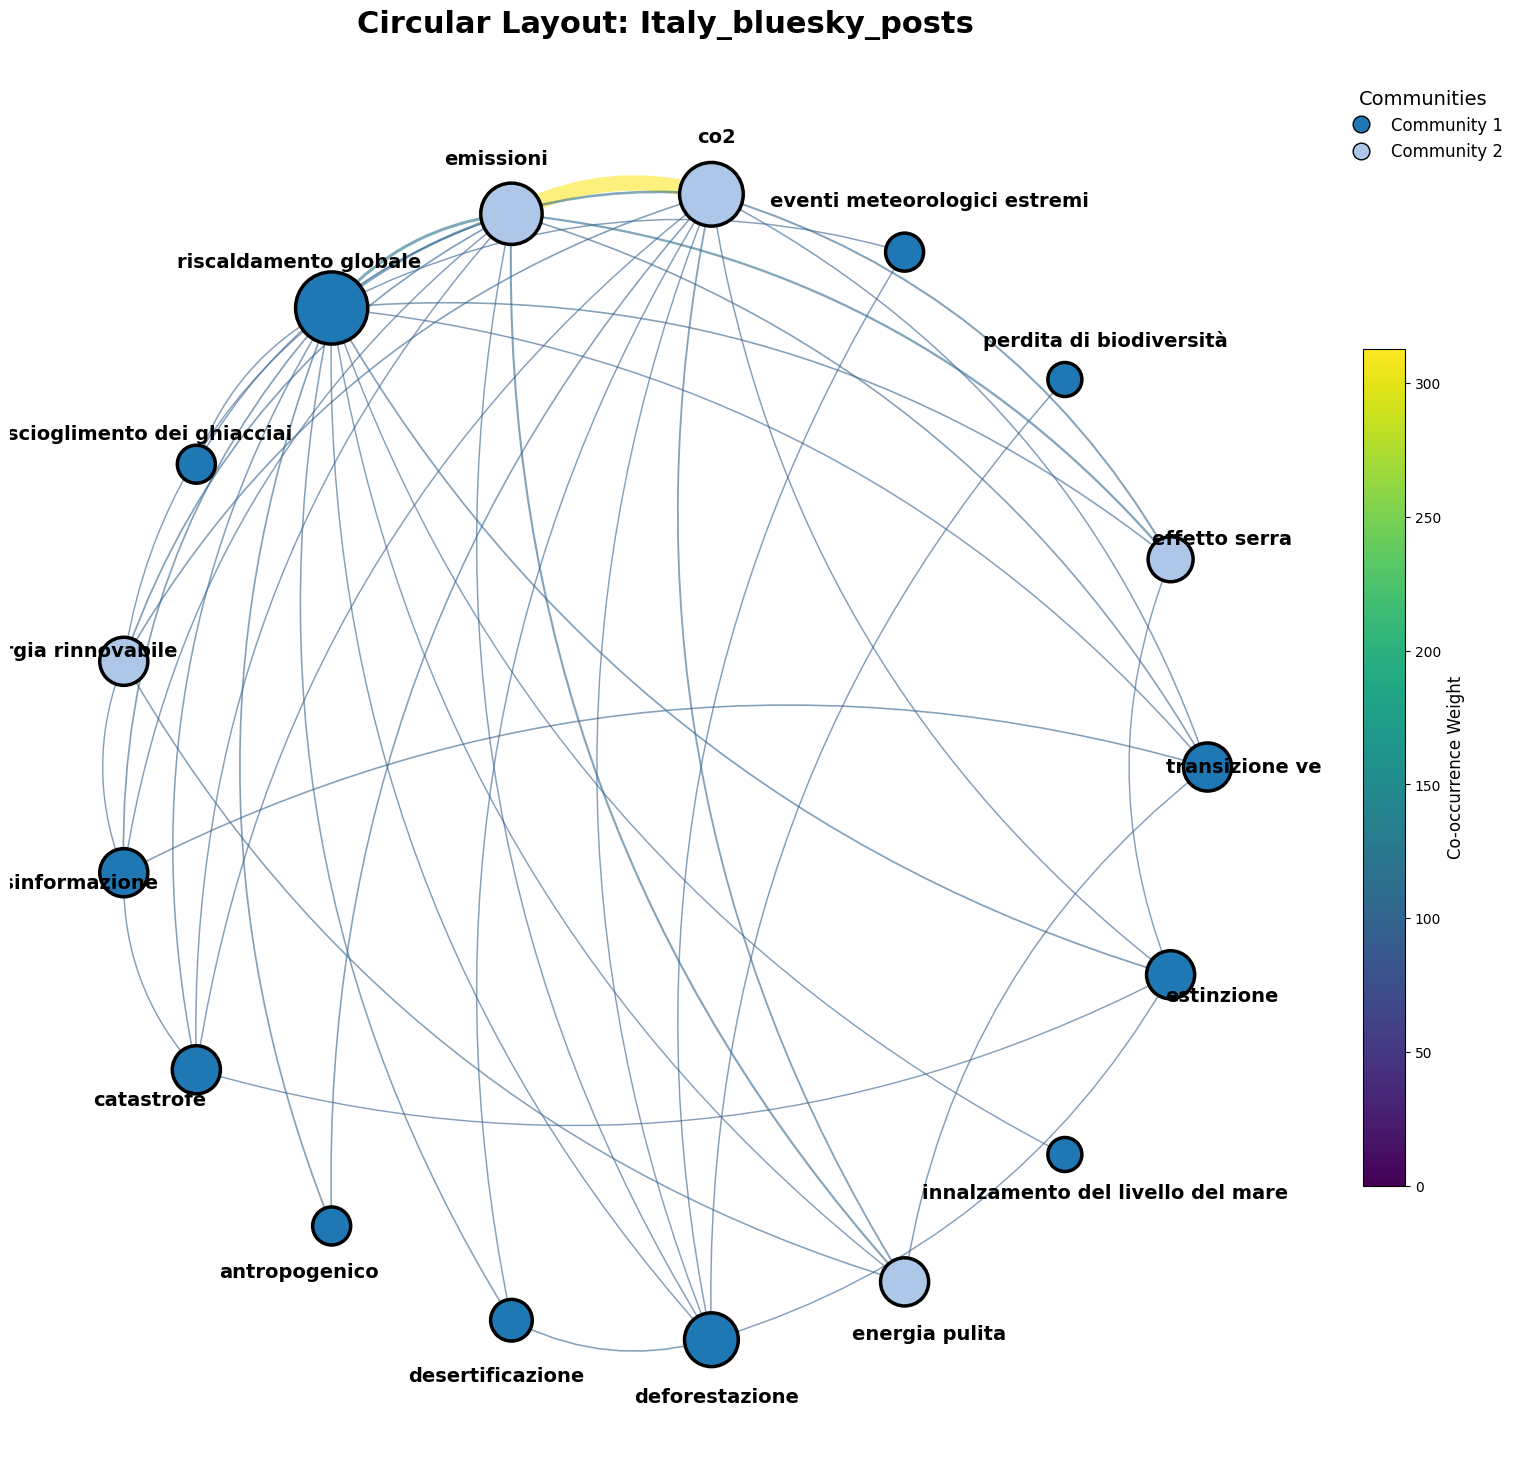

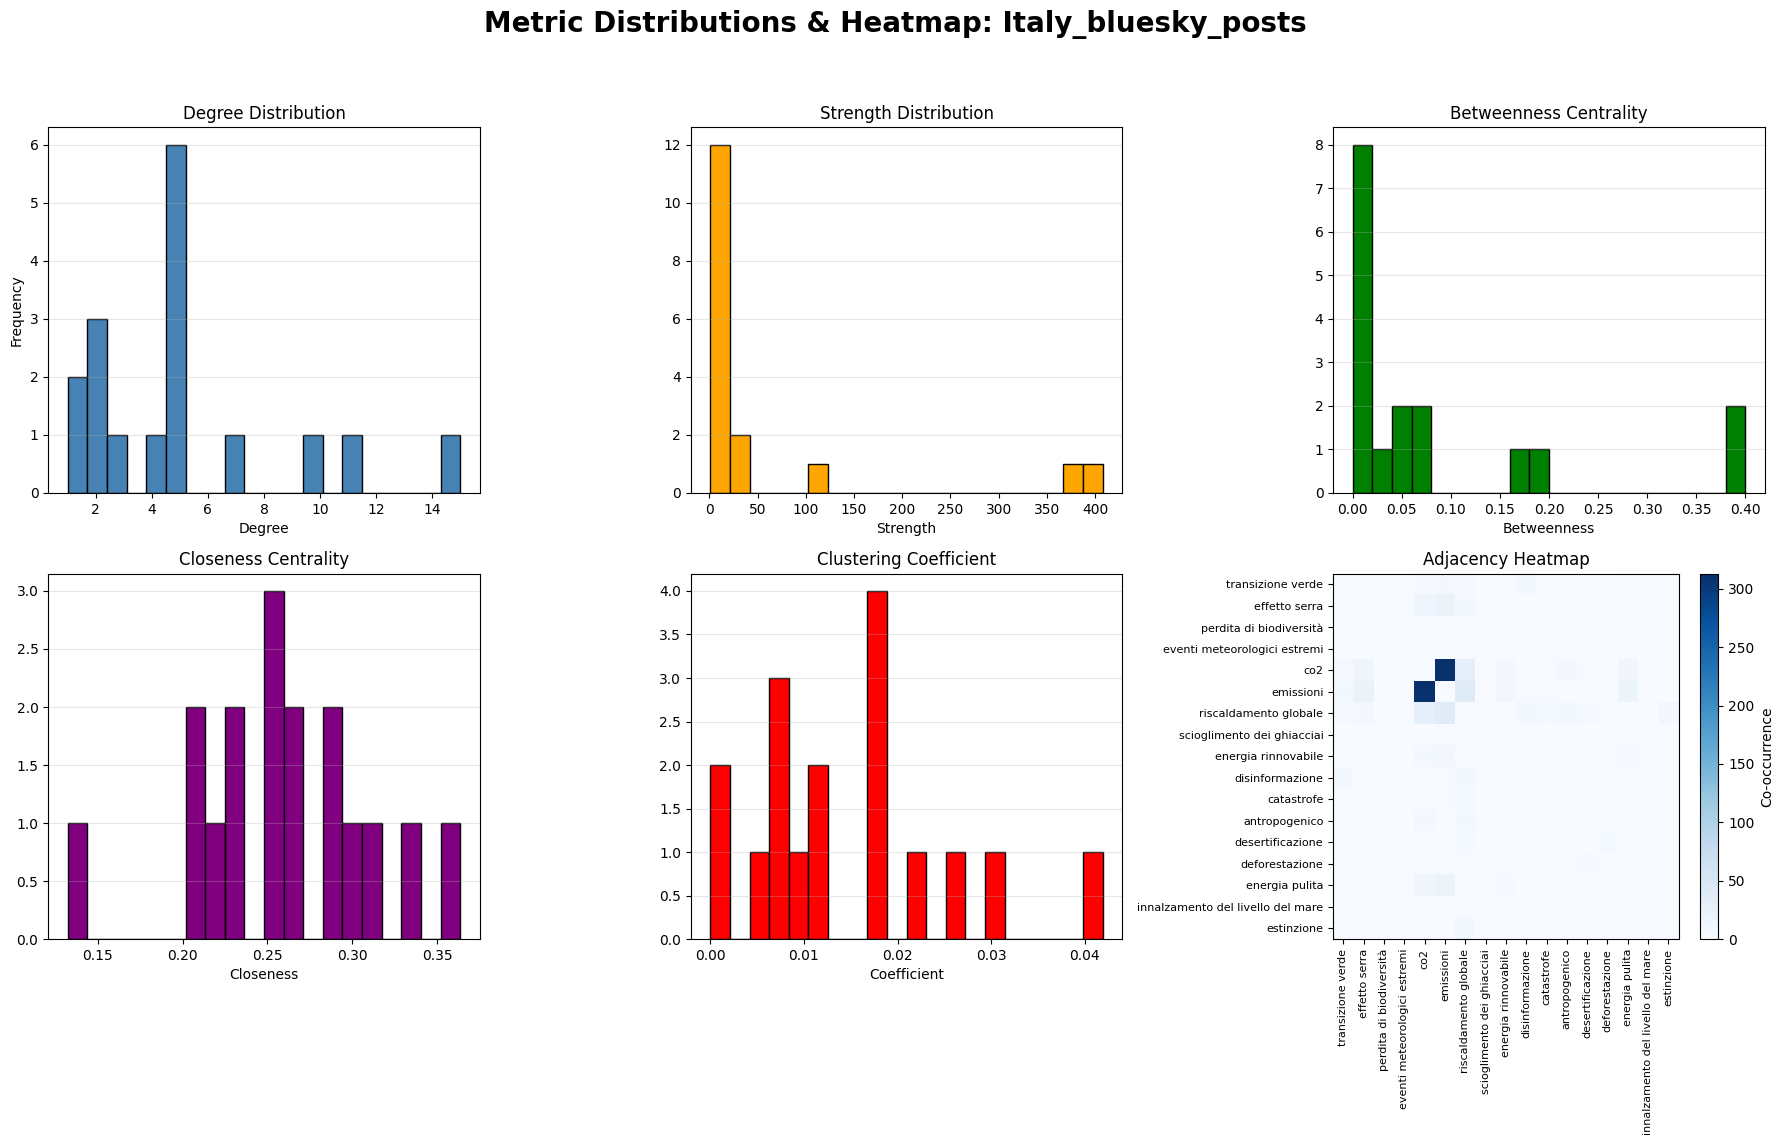

Interactive graph saved to ./analysis_results\Italy_bluesky_posts\interactive_graph.html
Loading ./downloaded_data\Portugal_bluesky_posts.csv...
Loaded 12409 posts.

ANALYZING: Portugal_bluesky_posts
Unique Keywords found: 18
Computing co-occurrences...


Indexing keywords:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating Pairs:   0%|          | 0/153 [00:00<?, ?it/s]

Found 82 pairs with co-occurrences >= 1
Co-occurrence data saved to co_occurrences.csv
Graph constructed: 18 nodes, 82 edges.
Metrics saved to node_metrics.csv
Global metrics saved to global_metrics.csv


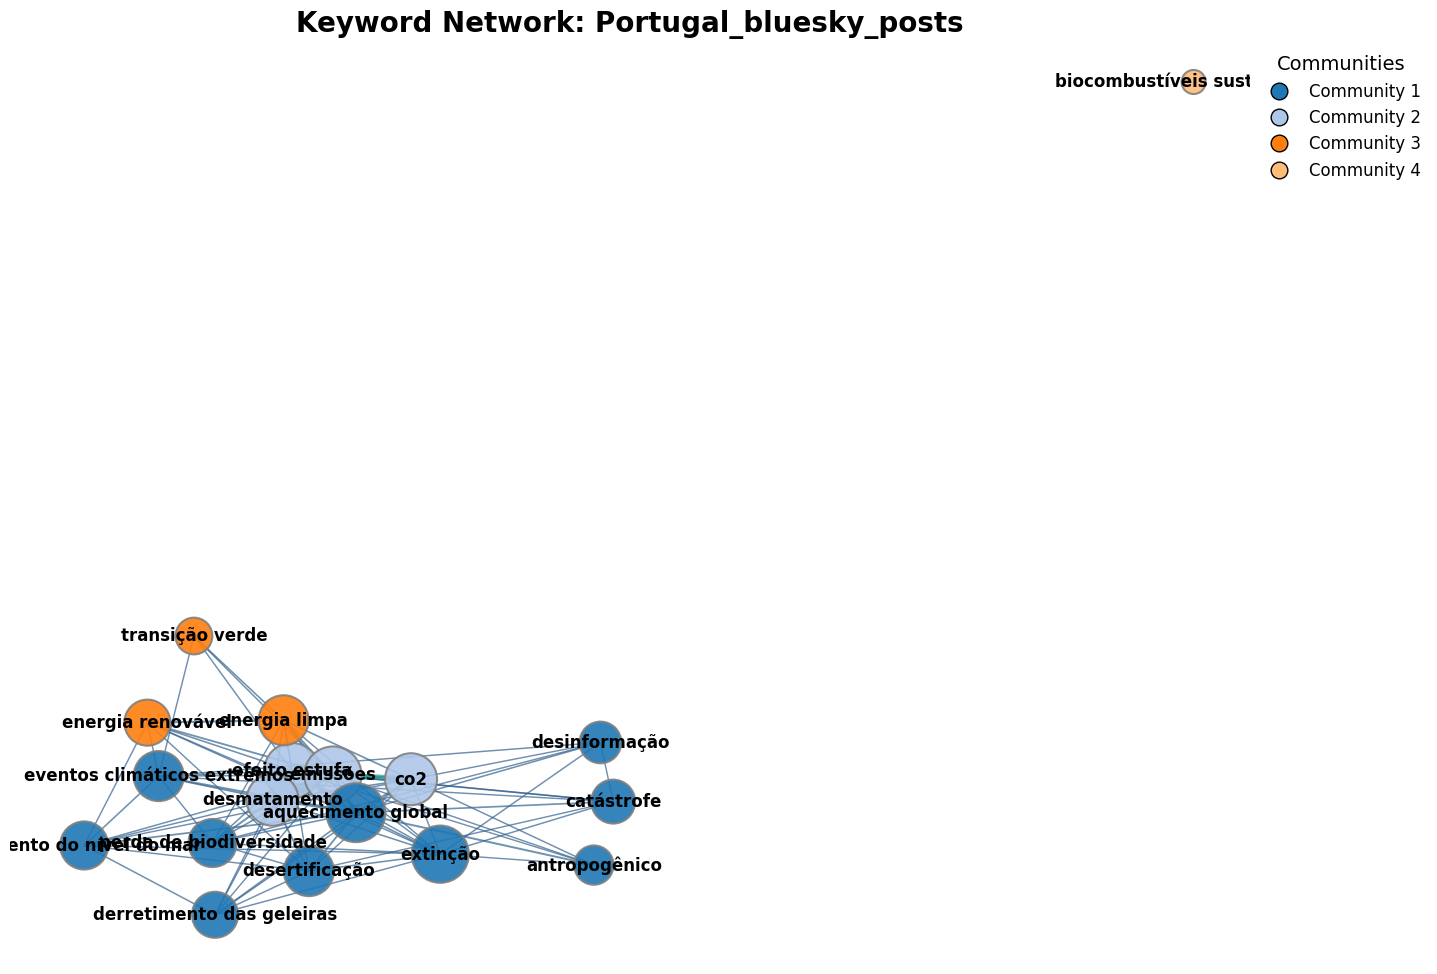

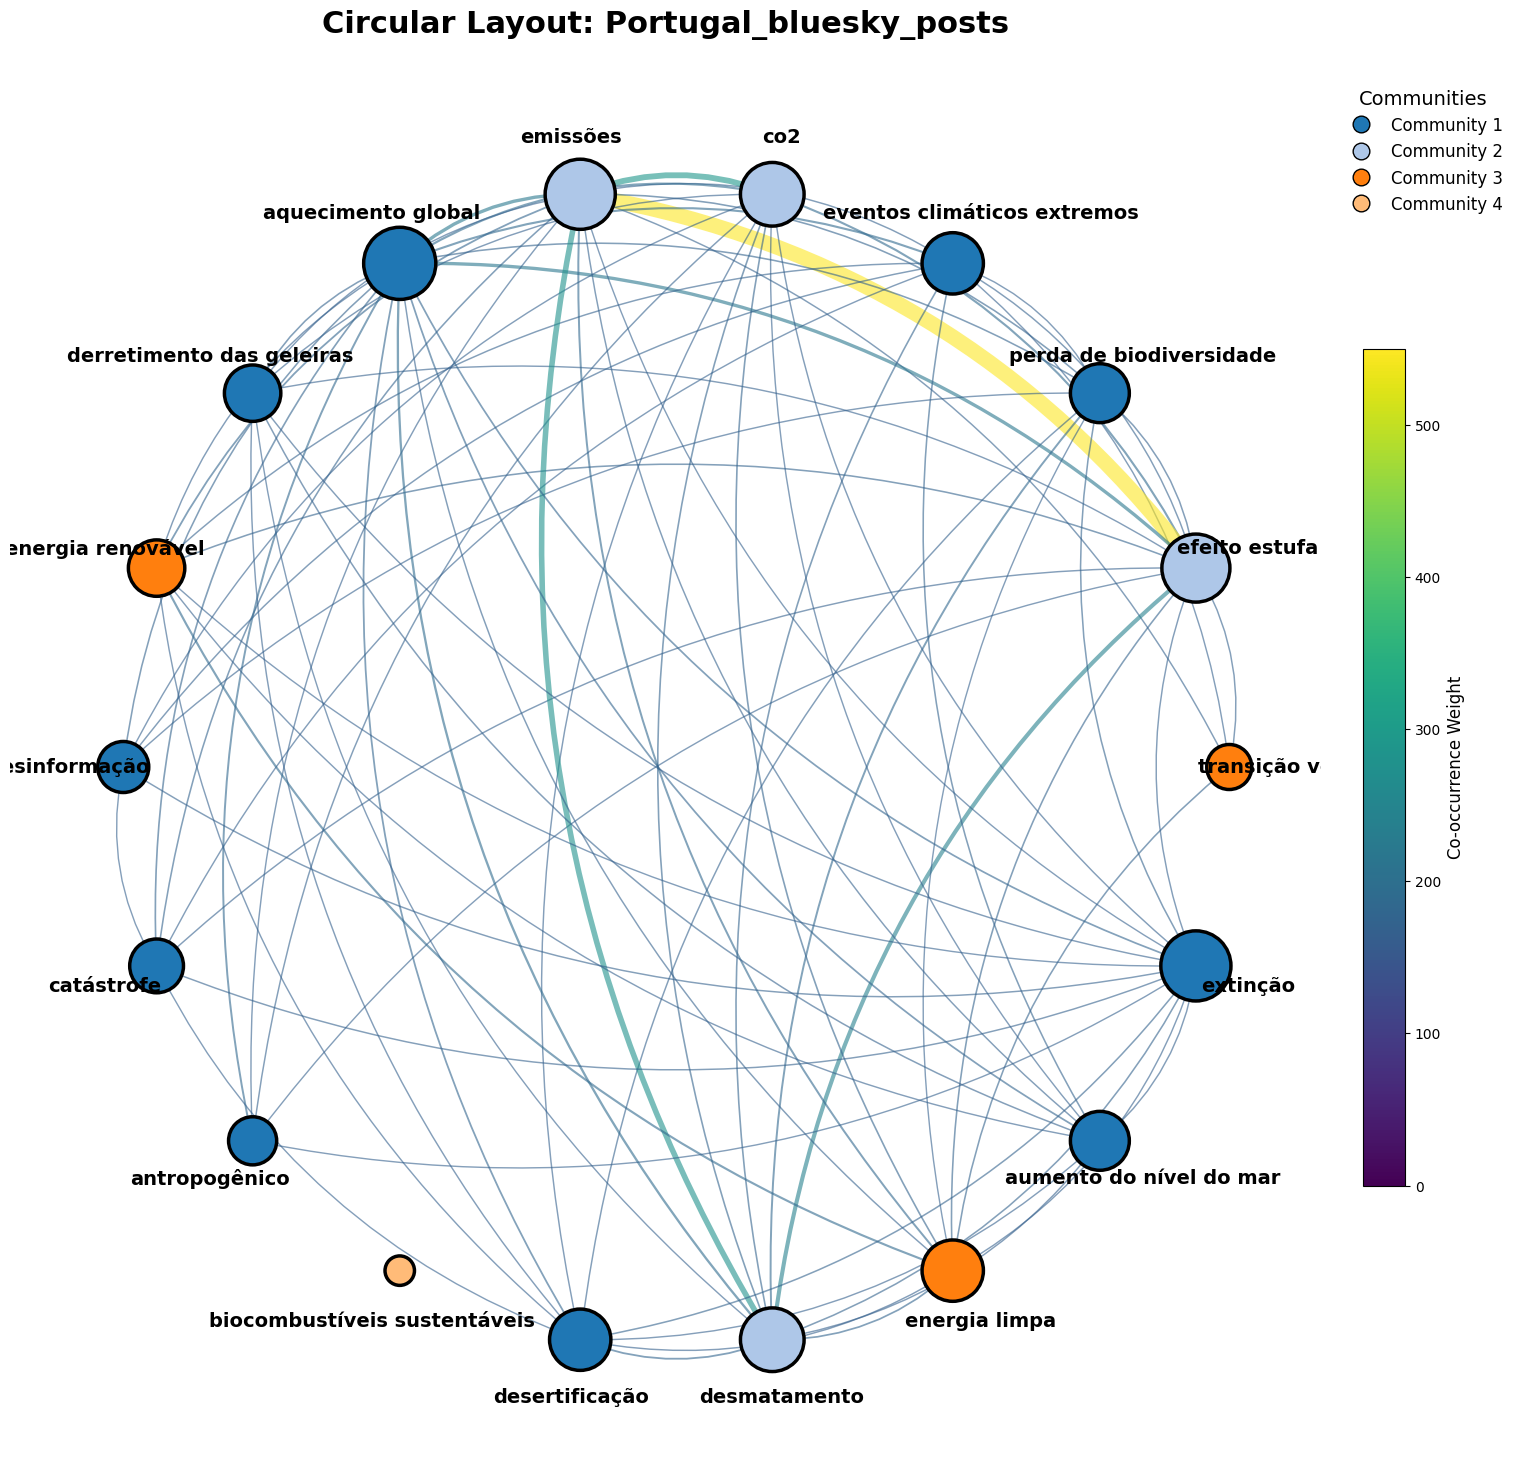

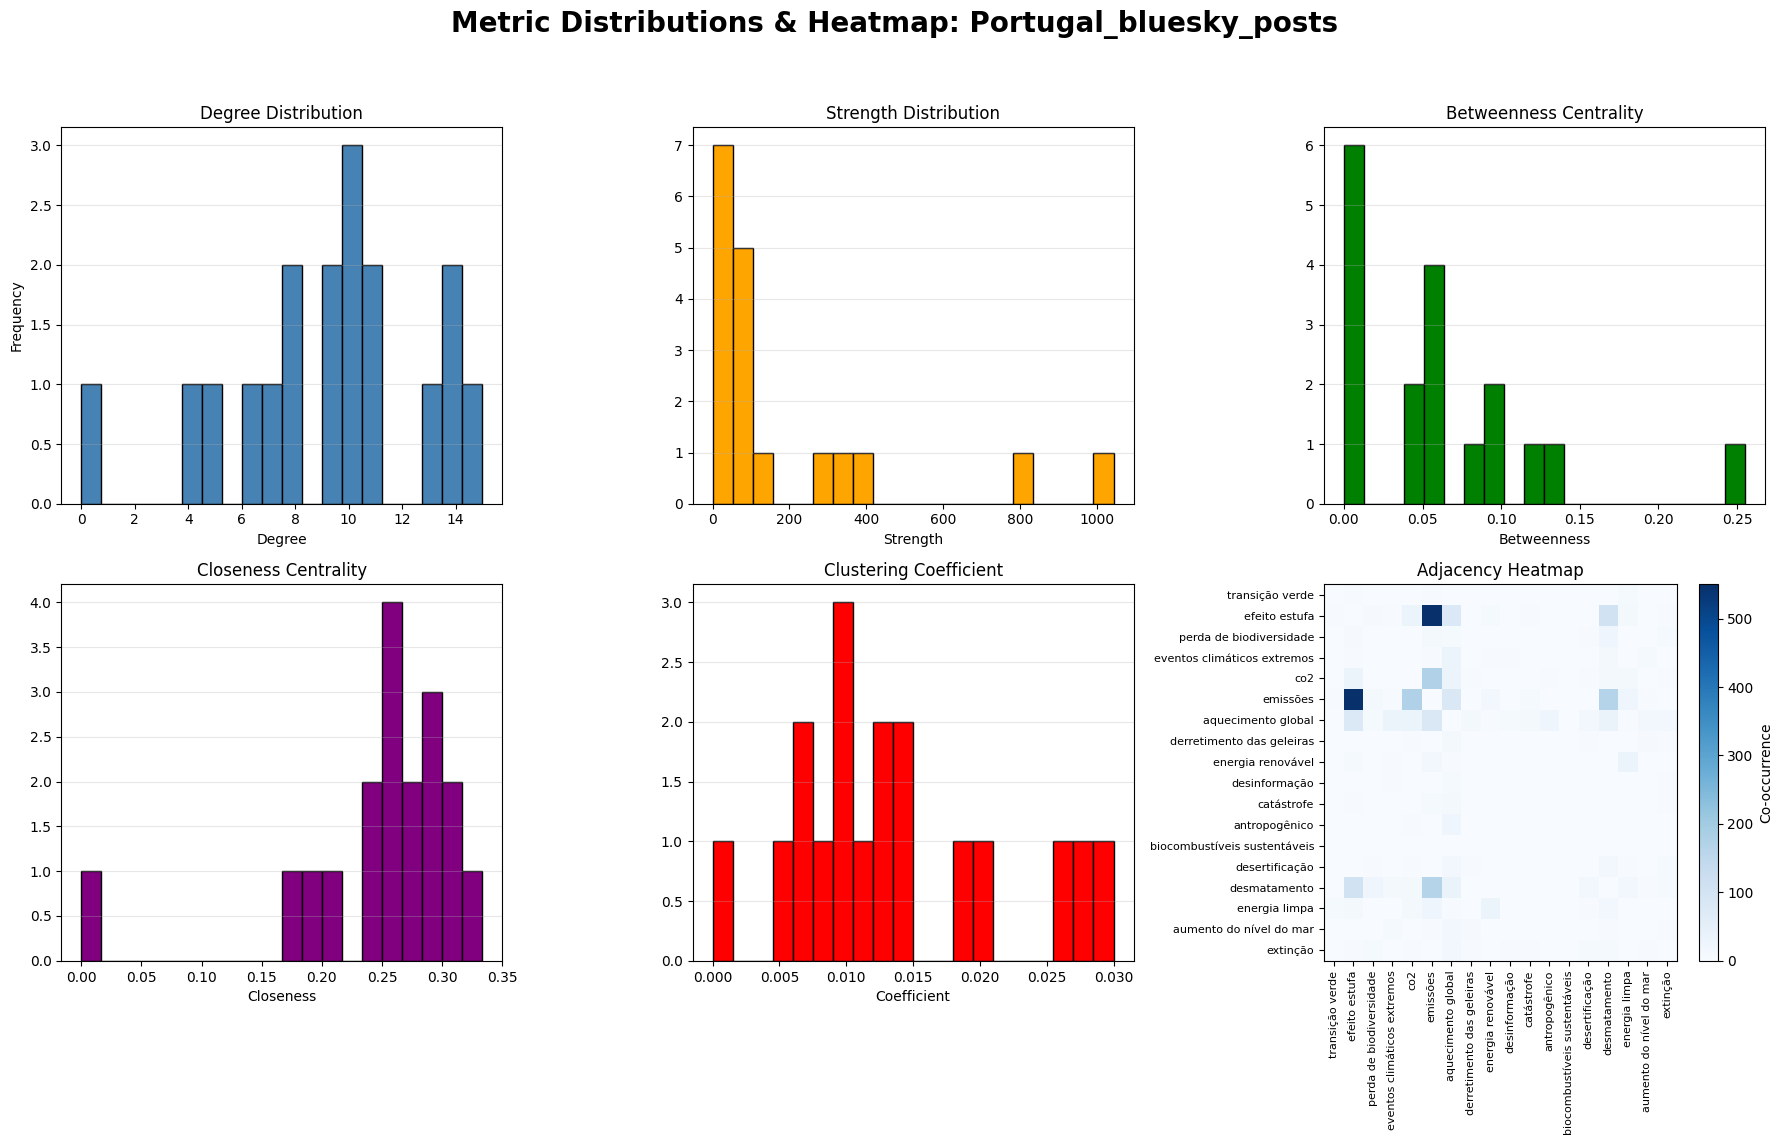

Interactive graph saved to ./analysis_results\Portugal_bluesky_posts\interactive_graph.html
Loading ./downloaded_data\Spain_bluesky_posts.csv...
Loaded 12233 posts.

ANALYZING: Spain_bluesky_posts
Unique Keywords found: 18
Computing co-occurrences...


Indexing keywords:   0%|          | 0/18 [00:00<?, ?it/s]

Calculating Pairs:   0%|          | 0/153 [00:00<?, ?it/s]

Found 73 pairs with co-occurrences >= 1
Co-occurrence data saved to co_occurrences.csv
Graph constructed: 18 nodes, 73 edges.
Metrics saved to node_metrics.csv
Global metrics saved to global_metrics.csv


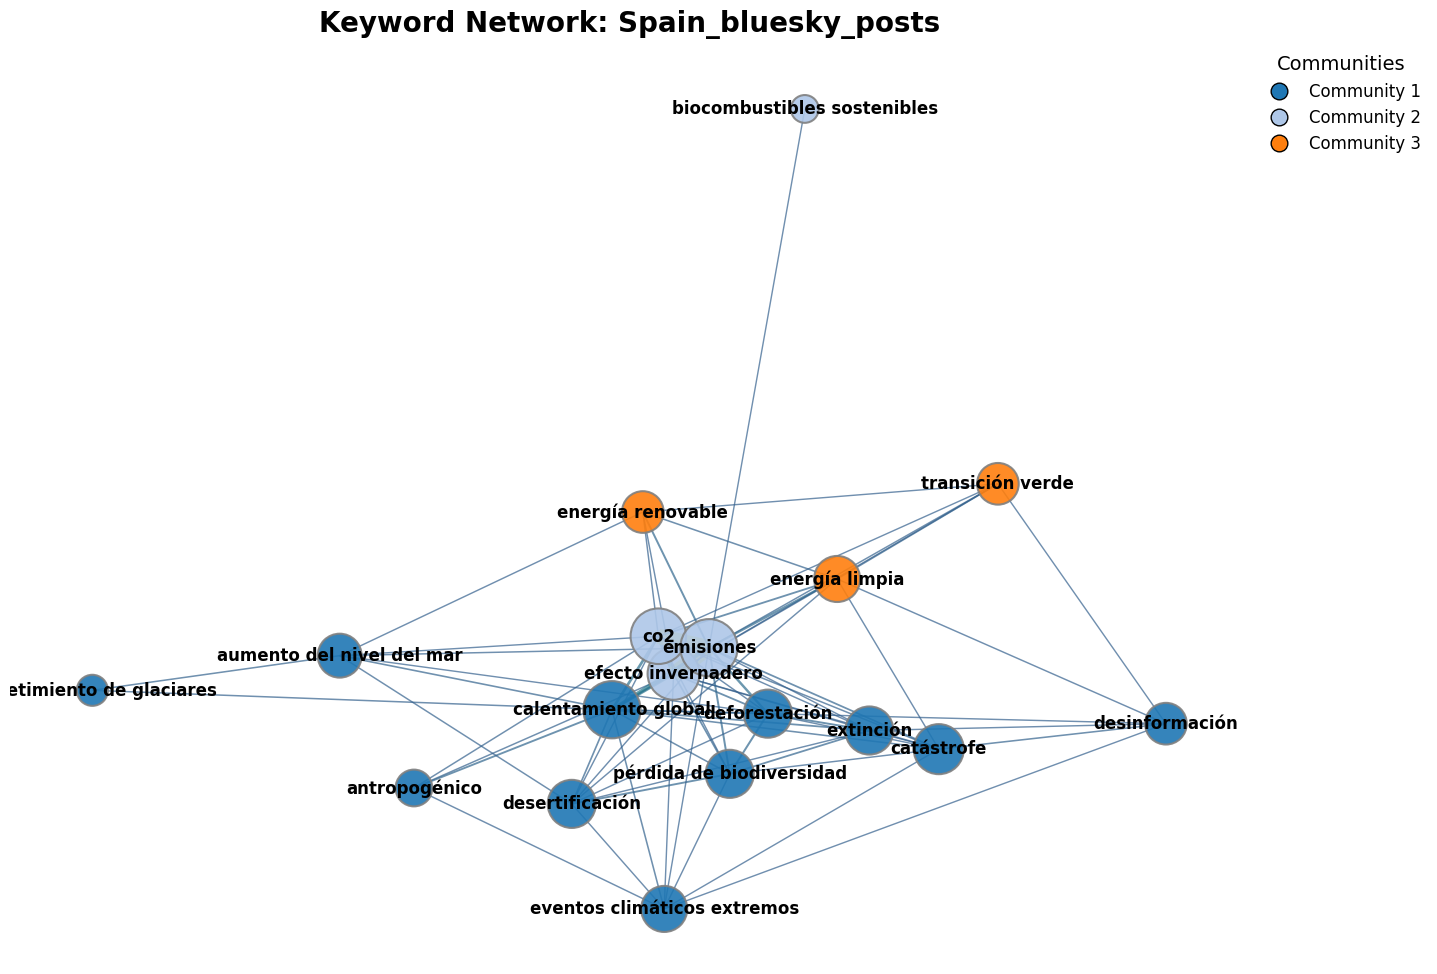

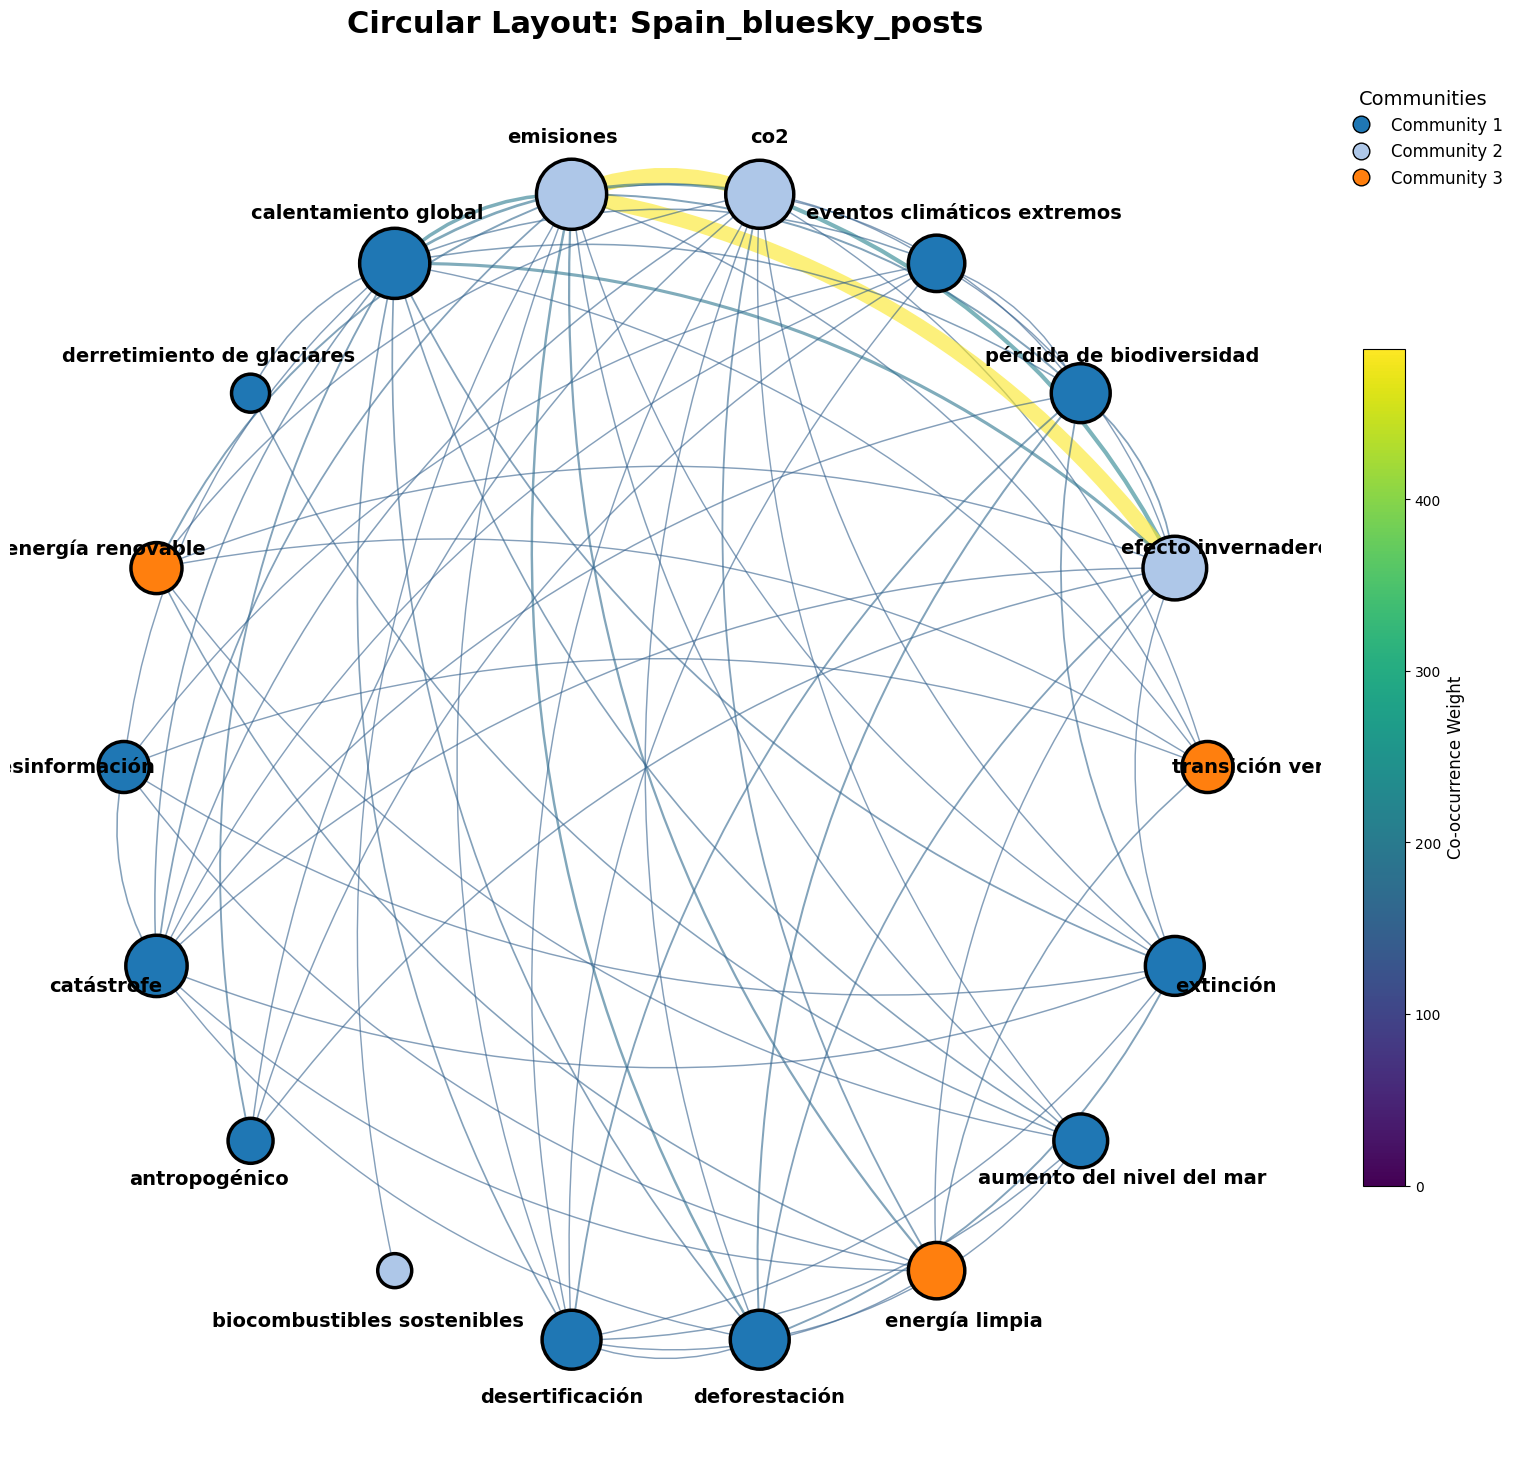

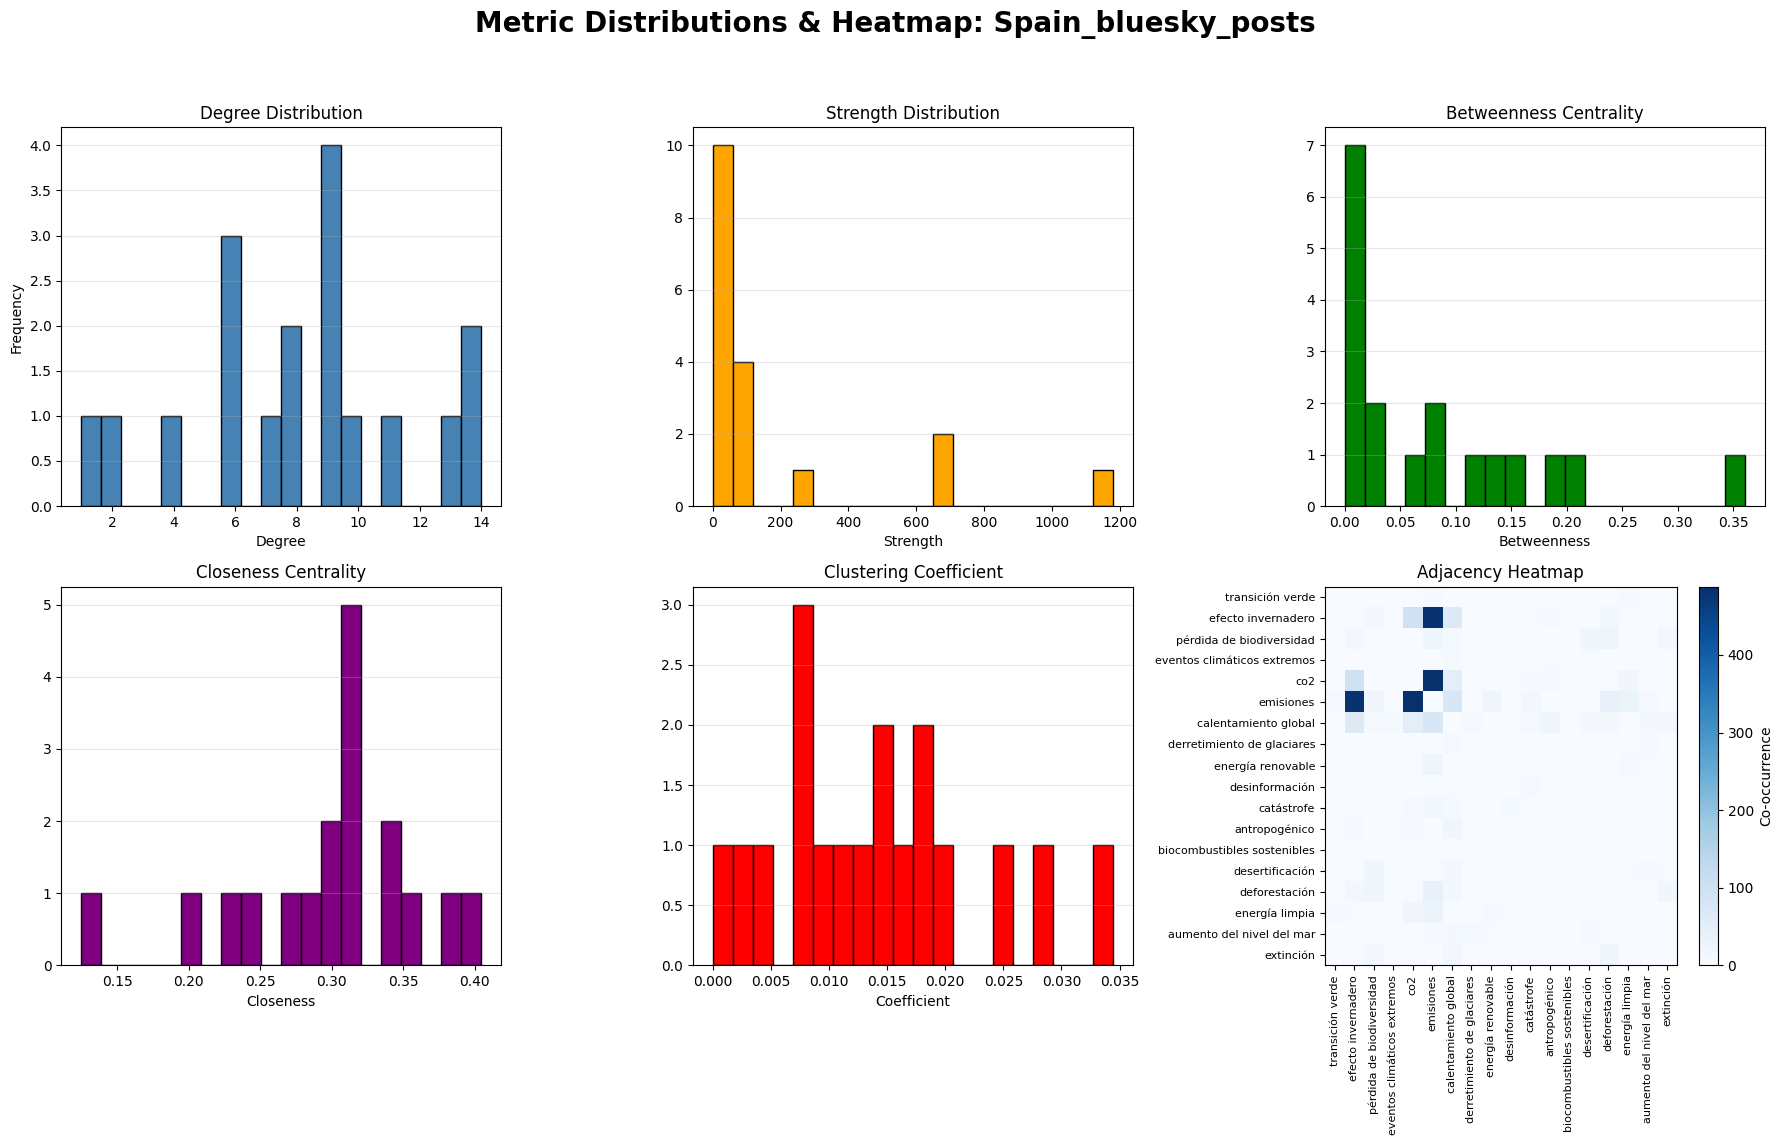

Interactive graph saved to ./analysis_results\Spain_bluesky_posts\interactive_graph.html


In [18]:
# Execute Analysis for all CSV files in data directory
count = 0
if os.path.exists(INPUT_DIR):
    for filename in os.listdir(INPUT_DIR):
        if filename.endswith(".csv") and "metrics" not in filename:
            config_name = filename.replace(".csv", "")
            df = load_dataset(filename)
            if df is not None:
                G, metrics = analyze_network(df, config_name)
                count += 1
else:
    print(f"Directory {INPUT_DIR} does not exist.")
    
if count == 0:
    print("No CSV files found to analyze.")